In [450]:
%load_ext autoreload
%autoreload 2

import icon_registration
import icon_registration.data as data
import icon_registration.networks as networks
import icon_registration.network_wrappers as network_wrappers
import icon_registration.visualize as visualize
import icon_registration.train as train
import icon_registration.config as config
import icon_registration.inverseConsistentNet as inverseConsistentNet
from icon_registration.mermaidlite import compute_warped_image_multiNC

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
import pickle
from IPython.display import Image, display
import torch.nn.functional as F

In [48]:
def train_datasets(net, optimizer, data_loader, epochs=400):
    """A training function for quick experiments"""
    import tqdm
    from icon_registration.losses import to_floats
    
    batch_size = net.identity_map.shape[0]
    loss_history = []
    for epoch in tqdm.tqdm(range(epochs)):
        for d in list(data_loader):
            if True:  # A[0].size()[0] == batch_size:
                image_A = d[0][:, 0:1].to(icon_registration.config.device)
                image_B = d[0][:, 1:2].to(icon_registration.config.device)
                optimizer.zero_grad()

                loss_object = net(image_A, image_B)

                loss_object.all_loss.backward()
                optimizer.step()

            loss_history.append(to_floats(loss_object))
    return loss_history

In [4]:
def register(Arch, lmbda):
    inner_net = network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2))

    for _ in range(2):
        inner_net = network_wrappers.DoubleNet(network_wrappers.DownsampleNet(inner_net, 2), network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

    net = Arch(
        inner_net,
        # Our image similarity metric. The last channel of x and y is whether the value is interpolated or extrapolated, 
        # which is used by some metrics but not this one
        inverseConsistentNet.LNCC(sigma=5),
        #ssd,
        lmbda,
    )
    network_wrappers.assignIdentityMap(net, input_shape)
    net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
    net.train()
    # y = train.train2d(net, optimizer, d1, d2, epochs=60)
    y = train_datasets(net, optimizer, retina, epochs=60)
    
    return y, net
    
    # return np.mean(y[-40:], axis=0)

In [5]:
inverseConsistentNet.ICONLoss.__doc__

'ICONLoss(all_loss, inverse_consistency_loss, similarity_loss, transform_magnitude, flips)'

In [43]:
# batch_size = 10
# d1, d2 = data.get_dataset_triangles("train", hollow=True, data_size=32)
# d1_t, d2_t = data.get_dataset_triangles("test", hollow=True, data_size=32)

d1, d2 = data.get_dataset_retina(extra_deformation=False, downsample_factor=2, blur_sigma=1, warps_per_pair=20)
retina = torch.torch.utils.data.DataLoader(torch.torch.utils.data.TensorDataset(torch.cat([d1.dataset.tensors[0], d2.dataset.tensors[0]], dim=1)), batch_size=10, shuffle=True)

input_shape = next(iter(retina))[0].shape


In [483]:
d = next(iter(retina))[0]
d.shape

torch.Size([10, 2, 292, 282])

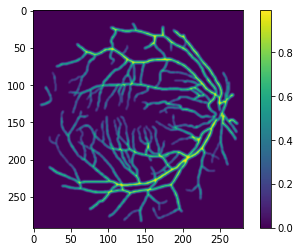

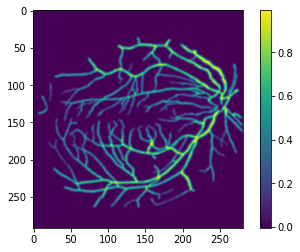

In [44]:
d = next(iter(retina))[0]
plt.imshow(d[0,0].numpy())
plt.colorbar()
plt.show()

plt.imshow(d[0,1].numpy())
plt.colorbar()
plt.show()

## Run once per regularizer to find a suitable lambda_0

In [459]:
# loss_res, net = register(inverseConsistentNet.DiffusionRegularizedNet, 1.5)
loss_res, net = register(inverseConsistentNet.BendingEnergyNet, 7e-4)
# loss_res, net = register(inverseConsistentNet.InverseConsistentNet, 1.5e3)
# loss_res, net = register(inverseConsistentNet.GradientICON, 1.5)

100%|██████████| 60/60 [02:15<00:00,  2.26s/it]


In [460]:
l = np.mean(np.array(loss_res)[-40::], 0)
vol = np.prod(input_shape[2:])
l[-1] / vol * 100.0

8.197318529823275e-05

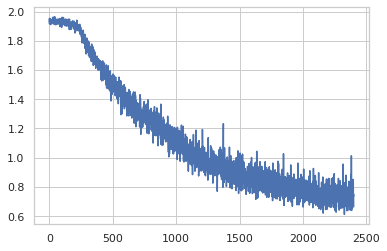

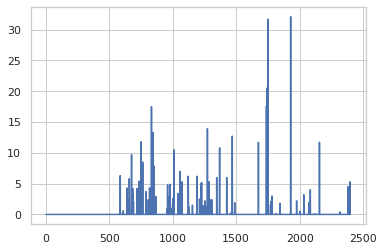

In [456]:
plt.plot([i.similarity_loss for i in loss_res])
plt.show()
plt.plot([i.flips for i in loss_res])
plt.show()

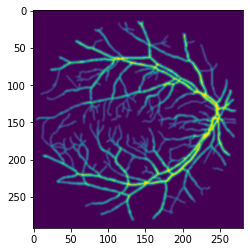

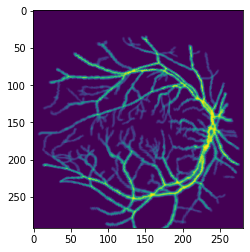

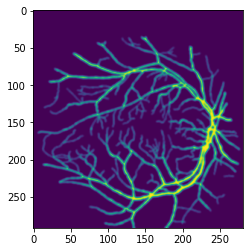

In [13]:
d = next(iter(retina))[0]
with torch.no_grad():
    _ = net(d[:,:1].cuda(), d[:,1:2].cuda())
warped = compute_warped_image_multiNC(
                d[:,:1].cuda(), net.phi_AB_vectorfield, net.spacing, spline_order=0
            ).cpu()

# sns.set_style('white')
plt.imshow(d[0,0])
plt.show()
plt.imshow(warped[0,0])
plt.show()
plt.imshow(d[0,1])
plt.show()

## Set the lambda_0 for all regularizers

In [468]:
models = [
    ["Bending Energy", inverseConsistentNet.BendingEnergyNet, 6e-4],
    ["Diffusion", inverseConsistentNet.DiffusionRegularizedNet, 1.5],
    ["ICON", inverseConsistentNet.InverseConsistentNet, 1.5e3],
    ["GradICON", inverseConsistentNet.GradientICON, 1.5]
]

In [467]:


num_of_run = 1
results = {}
for name, model, lmbda_0 in models:
    results[name] = []
    for i in (-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6):
        lmbda = lmbda_0 * 2**i
        res = []
        for _ in range(num_of_run):
            res.append(register(model, lmbda))
        results[name].append(res)
        
        
        
        

/playpen-raid2/lin.tian/projects/icon_lung/ICON/src/icon_registration/network_wrappers.py:256: UserWarning: /tmp/ipykernel_1243425/3026948548.py:15 - assignIdentityMap is deprecated. use net.assign_identity_map
  warnings.warn("%s:%d - %s" % (caller.filename, caller.lineno, message))
100%|██████████| 60/60 [02:12<00:00,  2.21s/it]


In [469]:
# Separate the loss data from results
loss_data = {}
for i, (name, model, lmbda_0) in enumerate(models):
    res = results[name]
    loss_data[name] = []
    for j in range(len(res)): # varying lambda
        loss_data[name].append([_[0] for _ in res[j]])

In [429]:
def get_metrics(result, input_shape):
    res = np.mean(np.array(result)[:,:,-100::], 2)
    vol = np.prod(input_shape[2:])
    sims = res[:,:,-3]/2.0
    perc_fold = res[:,:,-1] / vol * 100.0
    return np.mean(sims, 1), np.mean(perc_fold, 1), np.std(sims, 1), np.std(perc_fold, 1)

def get_loss_curve(result):
    return np.array(result)[:,:,:,-3], np.array(result)[:,:,:,-2], np.array(result)[:,:,:,-1]

def save_model(results, models, scheduler, output_folder=''):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, (name, model, lmbda_0) in enumerate(models):
        for j, s in enumerate((-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6)):
            torch.save(results[name][j][0][1].state_dict(), output_folder + f"/{name}_{s}")

In [ ]:
# Save all the experiment data
import pickle
output_folder = 'figures/comparing_to_other_regularity/retina'
with open(f'{output_folder}/retina_exp_loss_curve.pickle', 'wb') as f:
    pickle.dump(loss_data, f, protocol=pickle.HIGHEST_PROTOCOL)

save_model(results, models, (-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6), f'{output_folder}/model_weight')
torch.save(retina.dataset.tensors[0], f'{output_folder}/dataset')

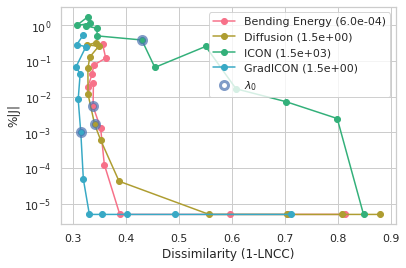

In [472]:
import seaborn as sns

epslin = 5e-6

fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
sns.set(style="whitegrid")

sim_for_lambda_0 = {}
for i, (name, model, lmbda_0) in enumerate(models):
    sim, flips, sim_std, flips_std = get_metrics(loss_data[name], input_shape)
    # meanst = np.array(means.ix[i].values[3:-1], dtype=np.float64)
    # sdt = np.array(stds.ix[i].values[3:-1], dtype=np.float64)
    # ax.plot(sim, flips+epslin, label=f"{name} ("+r'$\lambda_0$'+f"={lmbda_0:.1e})", c=clrs[i], marker='o')
    ax.plot(sim, flips+epslin, label=f"{name} ({lmbda_0:.1e})", c=clrs[i], marker='o')
    # ax.fill_between(sim, flips+epslin-flips_std, flips+epslin+flips_std ,alpha=0.3, facecolor=clrs[i])
    sim_for_lambda_0[sim[int(len(sim)/2)]] = flips[int(len(sim)/2)]

sim_for_lambda_0 = np.array([[i, sim_for_lambda_0[i]] for i in sorted(sim_for_lambda_0.keys())])
ax.plot(sim_for_lambda_0[:,0], sim_for_lambda_0[:,1], 'o', markersize=8, markeredgewidth=3, mfc='none', alpha=0.7, label='$\lambda_0$')
ax.legend()
plt.ylabel( "%|J|" )
plt.xlabel( "Dissimilarity (1-LNCC)")
# ax.set_xscale('log')
ax.set_yscale('log')

# plt.ylim((-0.1, 1.00))
plt.savefig(f'{output_folder}/retina_various_lambda_comparison.pdf', format='pdf', bbox_inches='tight', dpi=300)

## Plot warped images horizontally

In [477]:
import matplotlib.colors as colors

def show_as_grid(ax, phi, linewidth=1):
    data_size = phi.size()[-1]
    plot_phi = data_size * phi[:, ::2, ::2] - 0.5
    ax.set_xlim([-0.5, phi.size()[-2] - 0.5])
    ax.set_ylim([phi.size()[-1] - 0.5, -0.5])
    ax.plot(plot_phi[1], plot_phi[0], linewidth=linewidth, alpha=0.5)
    ax.plot(
        plot_phi[1].transpose(0, 1), plot_phi[0].transpose(0, 1), linewidth=linewidth, alpha=0.5
    )

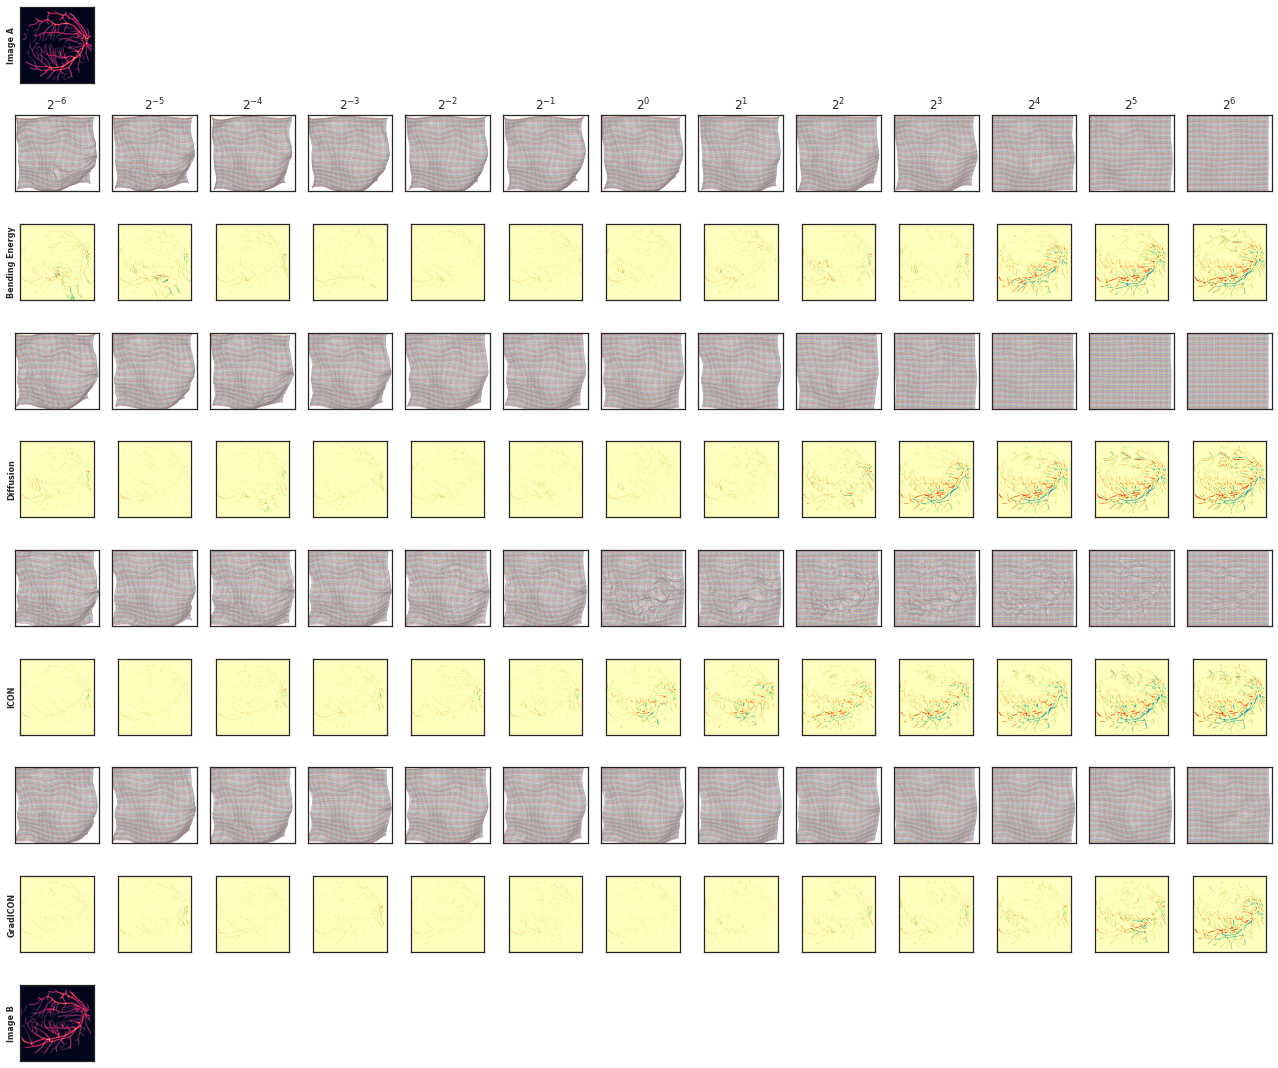

In [478]:
# Plot warped images horizontal
d = next(iter(retina))[0]
I1, I2 = d[:,0:1], d[:,1:2]
I1_cuda, I2_cuda = I1.cuda(), I2.cuda()
show_idx = 1

scheduler = (-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6)

fig, axes = plt.subplots(10, 13, figsize=(18,15))
sns.set(style="white")
for i, (name, model, lmbda_0) in enumerate(models):
    # sim_loss, mag_loss, fold_loss = get_loss_curve(loss_data[name])
    for j, s in enumerate((-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6)):
        lmbda = lmbda_0 * 2**s
        net = results[name][j][0][1]
        with torch.no_grad():
            _ = net(I1_cuda, I2_cuda)
            warped = compute_warped_image_multiNC(
                            I1_cuda, net.phi_AB_vectorfield, net.spacing, spline_order=0
                        ).cpu()
        
        ax_grid, ax_img = axes[1+i*2, j], axes[2+i*2, j]
        show_as_grid(ax_grid, net.phi_AB_vectorfield[show_idx].detach().cpu(), linewidth=0.5)
        ax_grid.set_xticks([])
        ax_grid.set_yticks([])

        norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
        ax_img.imshow(warped[show_idx,0]-I2[show_idx,0], norm=norm, cmap=sns.color_palette("Spectral", as_cmap=True))
        ax_img.set_xticks([])
        ax_img.set_yticks([])

        if i == 0:
            ax_grid.set_title(f"$2^{{{s}}}$", fontweight="bold")
            # axes[j,i+1].yaxis.set_label_coords(0.08, 0.5)
        if j == 0:
            ax_img.set_ylabel(name, fontsize=8, fontweight="bold")

axes[0,0].imshow(I1[show_idx,0])
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].set_ylabel("Image A", fontsize=8, fontweight="bold")

axes[-1,0].imshow(I2[show_idx,0])
axes[-1,0].set_xticks([])
axes[-1,0].set_yticks([])
axes[-1,0].set_ylabel("Image B", fontsize=8, fontweight="bold")


for i in [0,-1]:
    for j in range(1,13):
        axes[i,j].axis('off')

# plt.show()
plt.tight_layout()
plt.savefig(f'{output_folder}/retina_various_lambda_comparison_residual_of_warped_horizontal.pdf', format='pdf', bbox_inches='tight', dpi=300)


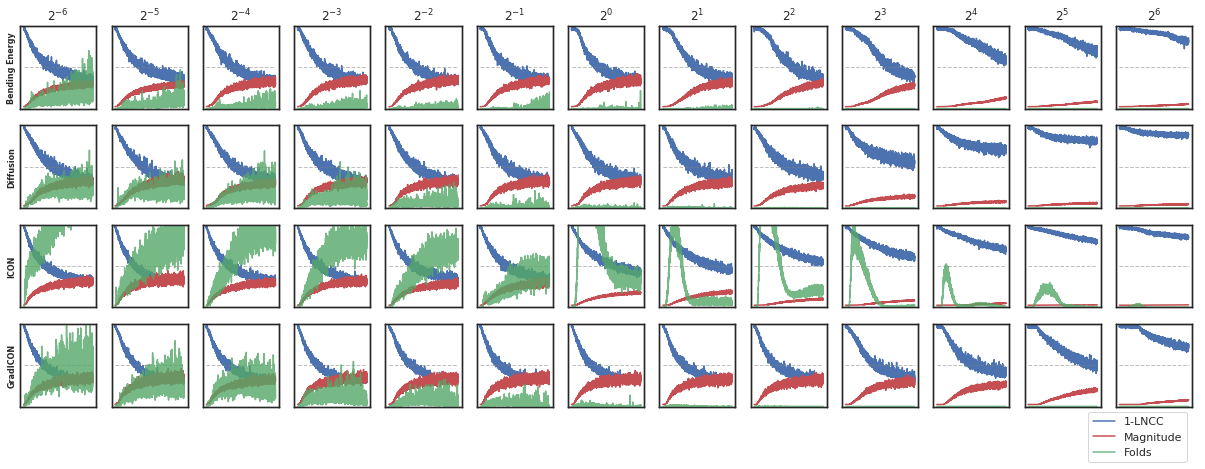

In [481]:
# Plot loss curve horizontal
def plot_loss_curve(ax, sim, mag, folds):
    font_size = 5

    twin1 = ax.twinx()
    twin2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    # twin2.spines.right.set_position(("axes", 1.2))

    p1, = ax.plot(sim, "b-", label="1-LNCC")
    p2, = twin1.plot(mag, "r-", label="Magnitude")
    p3, = twin2.plot(folds, "g-", label="Folds", alpha=0.8)

    # ax.set_yscale('log')
    # twin1.set_yscale('log')
    # twin2.set_yscale('log')

    # ax.set_xlabel("Iterations")
    # ax.set_ylabel("1-LNCC", fontsize=font_size)
    # twin1.set_ylabel("Magnitude", fontsize=font_size)
    # twin2.set_ylabel("Folds", fontsize=font_size)

    # ax.yaxis.label.set_color(p1.get_color())
    # twin1.yaxis.label.set_color(p2.get_color())
    # twin2.yaxis.label.set_color(p3.get_color())

    ax.set_ylim(0, 2)
    twin1.set_ylim(-1e-4, 4e-3)
    twin2.set_ylim(-1, 1000)

    # tkw = dict(size=2, width=1.5)
    # ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    # twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    # twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    ax.set_yticks([])
    twin1.set_yticks([])
    twin2.set_yticks([])
    return p1, p2, p3

fig, axes = plt.subplots(4, 13, figsize=(21,7))
sns.set(style="white")
for i, (name, model, lmbda_0) in enumerate(models):
    sim_loss, mag_loss, fold_loss = get_loss_curve(loss_data[name])
    for j, s in enumerate((-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6)):
        lmbda = lmbda_0 * 2**s
        _ = plot_loss_curve(axes[i,j], sim_loss[j,0], mag_loss[j,0], fold_loss[j,0])
        
        if j==0:
            axes[i,j].set_ylabel(name, fontsize=8, fontweight="bold")
        if i == 0:
            axes[i,j].set_title(f"$2^{{{s}}}$", fontsize=12, fontweight="bold")
            # axes[j,i].yaxis.set_label_coords(0.08, 0.5)

        axes[i,j].set_xticks([])
        axes[i,j].set_xlabel("")

        ymin, ymax = axes[i,j].get_ylim()
        axes[i,j].hlines(y=(ymin+ymax)/2.0, xmin=0, xmax=len(sim_loss[j,0]), colors='gray', linestyles='--', lw=1, alpha=0.5)
plt.legend(handles=_, bbox_to_anchor=(1, 0), loc='upper right')
# plt.show()
# plt.tight_layout()
plt.savefig(f'{output_folder}/retina_various_lambda_comparison_loss_curve_horizontal.pdf', format='pdf', bbox_inches='tight', dpi=300)

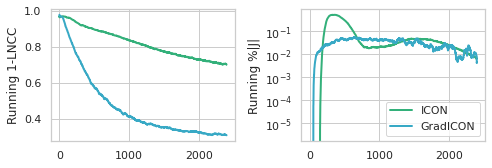

In [447]:
fig, axes = plt.subplots(1, 2, figsize=(7,2.5))
sns.set(style="whitegrid")

vol = np.prod(input_shape[2:])
# for i, (name, l) in enumerate([['Bending Energy',7], ['Diffusion',5], ['ICON',10], ['GradICON',5]]):
for i, (name, l) in enumerate([['ICON',10], ['GradICON',5]]):
    sim_loss, mag_loss, fold_loss = get_loss_curve(loss_data[name])
    fold_smooth = fold_loss[l,0]/vol*100.0
    fold_smooth = [np.mean(fold_smooth[max(j-40,0):j+1]) for j in range(fold_smooth.shape[0])]
    sim_smooth = sim_loss[l,0]/2.0
    sim_smooth = [np.mean(sim_smooth[max(j-40,0):j+1]) for j in range(sim_smooth.shape[0])]
    axes[0].plot(sim_smooth, label=name, lw=2, c=clrs[i+2])#, alpha=0.8**i)
    axes[0].set_ylabel('Running 1-LNCC')
    axes[1].plot(fold_smooth, label=name, lw=2, c=clrs[i+2])#, alpha=0.8**i)
    axes[1].set_ylabel('Running %|J|')
    axes[1].set_yscale('log')
    axes[1].legend()
plt.tight_layout()
plt.savefig(f'{output_folder}/retina_convergence_speed.pdf', format='pdf', bbox_inches='tight', dpi=300)